# AAI-521 Final Project – Group 3  
## 01 – DETRAC Dataset Exploration

**Goal:**  
Understand the UA-DETRAC dataset structure and annotations by:
- Verifying folder paths and files
- Parsing XML annotation files
- Visualizing sample frames with bounding boxes
- Exploring basic statistics of bounding boxes and frames

This notebook is exploratory only. No model training happens here.

#### Imports & Configuration

In [ ]:
import os
import sys
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# For pretty plots
plt.style.use("seaborn-v0_8")

# Root of the DETRAC dataset (adapt to your structure)
PROJECT_ROOT = Path().resolve().parent  # project root if notebooks/ is one level down
DATA_ROOT = PROJECT_ROOT / "data"

IMAGES_ROOT = DATA_ROOT / "DETRAC-Images"
TRAIN_ANN_ROOT = DATA_ROOT / "DETRAC-Train-Annotations"
TEST_ANN_ROOT = DATA_ROOT / "DETRAC-Test-Annotations"
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_detrac import load_detrac_annotations, VehicleClassifier, predict_vehicle_class

print("Images root:", IMAGES_ROOT)
print("Train annotations root:", TRAIN_ANN_ROOT)
print("Test annotations root:", TEST_ANN_ROOT)

# Choose one sequence for detailed exploration
SEQ_ID = "MVI_20011"
SEQ_IMAGES_DIR = IMAGES_ROOT / SEQ_ID
SEQ_TRAIN_ANN_FILE = TRAIN_ANN_ROOT / f"{SEQ_ID}.xml"

Images root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Images
Train annotations root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Train-Annotations
Test annotations root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Test-Annotations


#### Sanity Checks

In [2]:
assert IMAGES_ROOT.exists(), f"Images folder not found: {IMAGES_ROOT}"
assert TRAIN_ANN_ROOT.exists(), f"Train annotations folder not found: {TRAIN_ANN_ROOT}"

assert SEQ_IMAGES_DIR.exists(), f"Sequence folder not found: {SEQ_IMAGES_DIR}"
assert SEQ_TRAIN_ANN_FILE.exists(), f"Annotation XML not found: {SEQ_TRAIN_ANN_FILE}"

print("All key DETRAC paths exist ✅")

All key DETRAC paths exist ✅


## 1. Parse DETRAC XML Annotations

We load the UA-DETRAC XML format and convert it into a Python-friendly structure:

- Key: frame index (int)
- Value: list of dicts with:
  - `id` – vehicle track ID
  - `bbox` – `[left, top, width, height]`
  - `class` – vehicle type (car, bus, van, truck, etc.)

#### Load One Sequence & Basic Info

In [4]:
annotations = load_detrac_annotations(SEQ_TRAIN_ANN_FILE)

image_files = sorted(
    f for f in os.listdir(SEQ_IMAGES_DIR) if f.lower().endswith(".jpg")
)
frame_numbers = [int(f.replace("img", "").replace(".jpg", "")) for f in image_files]

print(f"Found {len(image_files)} image frames in {SEQ_IMAGES_DIR.name}")
print("First 5 frames:", image_files[:5])

Loaded annotations for 664 frames from MVI_20011.xml
Found 664 image frames in MVI_20011
First 5 frames: ['img00001.jpg', 'img00002.jpg', 'img00003.jpg', 'img00004.jpg', 'img00005.jpg']


## 2. Visualize a Sample Frame with Bounding Boxes

We overlay the bounding boxes onto a sample frame to confirm the
annotation format and alignment with the images.

#### Visualization Helper

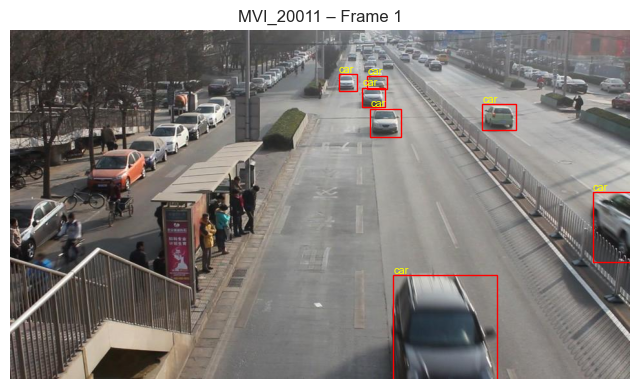

In [5]:
def show_frame_with_boxes(seq_images_dir, annotations, frame_num):
    img_file = f"img{frame_num:05d}.jpg"
    img_path = seq_images_dir / img_file

    if not img_path.exists():
        print(f"Image not found for frame {frame_num}: {img_path}")
        return

    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    ax.set_title(f"{seq_images_dir.name} – Frame {frame_num}")

    for target in annotations.get(frame_num, []):
        x, y, w, h = target["bbox"]
        rect = plt.Rectangle((x, y), w, h, fill=False, color="red", linewidth=1)
        ax.add_patch(rect)
        ax.text(x, y - 2, target["class"], color="yellow", fontsize=8)

    ax.axis("off")
    plt.show()

show_frame_with_boxes(SEQ_IMAGES_DIR, annotations, frame_num=1)

## 3. Visualize Multiple Frames

We next show several frames in a grid to get a qualitative feel for
traffic density, camera angle, and vehicle variety.

#### Multiple Frames Grid

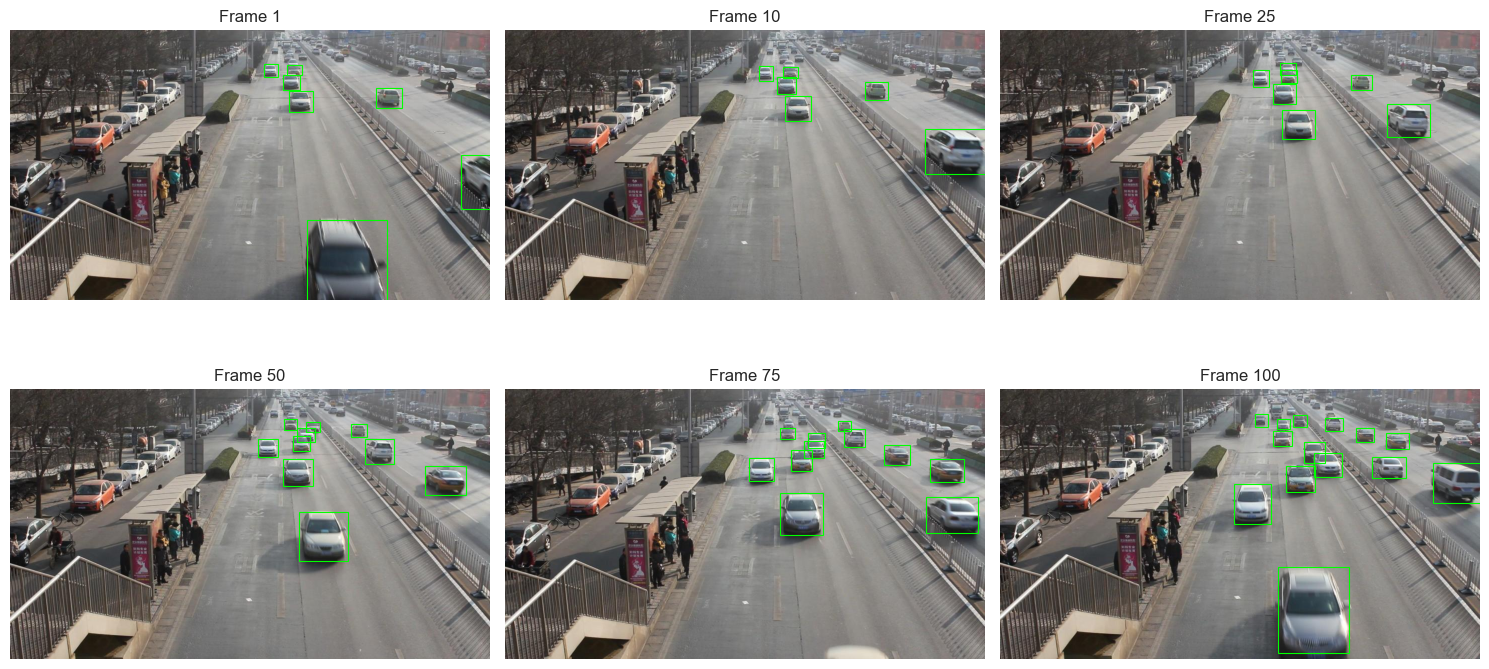

In [6]:
def show_frames_grid(seq_images_dir, annotations, frame_indices, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()

    for ax, fidx in zip(axes, frame_indices):
        img_file = f"img{fidx:05d}.jpg"
        img_path = seq_images_dir / img_file

        if not img_path.exists():
            ax.axis("off")
            continue

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(f"Frame {fidx}")

        for target in annotations.get(fidx, []):
            x, y, w, h = target["bbox"]
            rect = plt.Rectangle((x, y), w, h, fill=False, color="lime", linewidth=0.8)
            ax.add_patch(rect)

        ax.axis("off")

    plt.tight_layout()
    plt.show()

sample_indices = [1, 10, 25, 50, 75, 100]
show_frames_grid(SEQ_IMAGES_DIR, annotations, sample_indices)

## 4. Bounding Box Statistics

We summarize the distribution of vehicle bounding boxes in one sequence:

- Number of vehicles per frame
- Bounding box width/height
- Bounding box area
- Vehicle class frequencies

These statistics will appear in the report's EDA section.

#### Bounding Box Statistics

Frames with vehicles: 664
Mean vehicles per frame: 11.528614457831326
Bounding box width (mean, std): 50.59611234487263 32.04088096966129
Bounding box height (mean, std): 46.65976864794252 35.22487032706986
Bounding box area (mean, std): 3392.733557634226 5752.800977299735
Vehicle class counts: {'car': 7053, 'van': 296, 'others': 211, 'bus': 95}


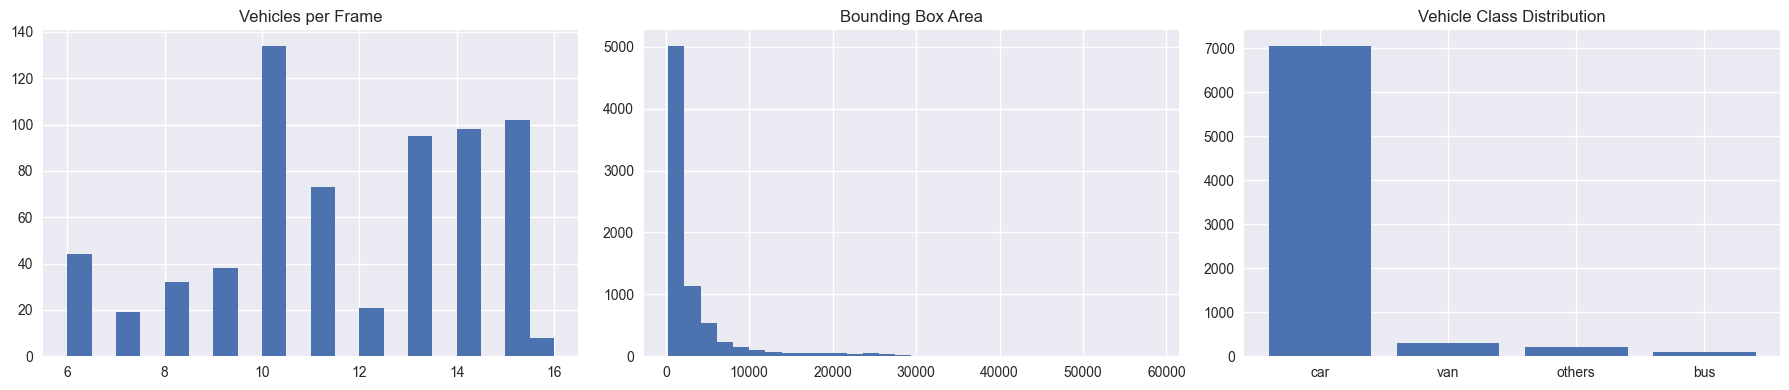

In [7]:
all_widths, all_heights, all_areas = [], [], []
vehicles_per_frame = []
class_counts = {}

for frame_num, targets in annotations.items():
    vehicles_per_frame.append(len(targets))
    for t in targets:
        x, y, w, h = t["bbox"]
        all_widths.append(w)
        all_heights.append(h)
        all_areas.append(w * h)
        cls = t["class"]
        class_counts[cls] = class_counts.get(cls, 0) + 1

# -----------------------------
# 🔧 Robust print section here
# -----------------------------
print("Frames with vehicles:", len(vehicles_per_frame))
print("Mean vehicles per frame:", np.mean(vehicles_per_frame))

if len(all_widths) > 0:
    print("Bounding box width (mean, std):", np.mean(all_widths), np.std(all_widths))
    print("Bounding box height (mean, std):", np.mean(all_heights), np.std(all_heights))
    print("Bounding box area (mean, std):", np.mean(all_areas), np.std(all_areas))
else:
    print("No bounding boxes found – check annotation parsing.")

print("Vehicle class counts:", class_counts)

# -----------------------------
# Plots (only shown if data exists)
# -----------------------------
if len(all_widths) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].hist(vehicles_per_frame, bins=20)
    axes[0].set_title("Vehicles per Frame")

    axes[1].hist(all_areas, bins=30)
    axes[1].set_title("Bounding Box Area")

    axes[2].bar(class_counts.keys(), class_counts.values())
    axes[2].set_title("Vehicle Class Distribution")

    plt.tight_layout()
    plt.show()
else:
    print("Skipping plots because no bounding boxes were parsed.")


## 5. Summary

- The DETRAC dataset is correctly organized under `data/DETRAC-*`.
- We confirmed that:
  - XML annotations align with the images.
  - Bounding boxes are reasonable in size.
  - Vehicle classes include: car, bus, van, truck, and others.
- These insights will guide our preprocessing and model design in the next notebooks.

Next step: create a cropped vehicle dataset suitable for training a CNN classifier.